# Activation Maximization

The idea behind activation maximization is simple in hindsight - Generate an input image that maximizes the filter output activations. i.e., we compute

$$\frac{\partial ActivationMaximizationLoss}{\partial input}$$

**NOTE**:

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear'. The reason is that maximizing an output node can be done by minimizing other outputs. Softmax is weird that way. It is the only activation that depends on other node output(s) in the layer.

**Caution**:

This NOTEBOOK will take time to run, since this visualization is **optimization** based

In [1]:
import numpy as np
np.random.seed(500)

In [2]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### Visualizing a specific output category

Lets try visualizing a specific output category. We will pick `ouzel` which corresponds to imagenet category `20`

In [3]:
from vis.visualization import visualize_activation

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

In [4]:
help(visualize_activation)

Help on function visualize_activation in module vis.visualization.activation_maximization:

visualize_activation(model, layer_idx, filter_indices=None, wrt_tensor=None, seed_input=None, input_range=(0, 255), backprop_modifier=None, grad_modifier=None, act_max_weight=1, lp_norm_weight=10, tv_weight=10, **optimizer_params)
    Generates the model input that maximizes the output of all `filter_indices` in the given `layer_idx`.
    
    Args:
        model: The `keras.models.Model` instance. The model input shape must be: `(samples, channels, image_dims...)`
            if `image_data_format=channels_first` or `(samples, image_dims..., channels)` if
            `image_data_format=channels_last`.
        layer_idx: The layer index within `model.layers` whose filters needs to be visualized.
        filter_indices: filter indices within the layer to be maximized.
            If None, all filters are visualized. (Default value = None)
            For `keras.layers.Dense` layer, `filter_idx` i

CPU times: user 5.51 s, sys: 1.72 s, total: 7.23 s
Wall time: 8.89 s


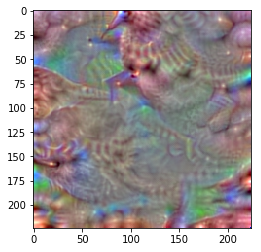

In [5]:
%%time
# 20 is the imagenet category for 'ouzel'
img = visualize_activation(model, layer_idx, filter_indices=20)
plt.imshow(img)

Hmm, that sort of looks like a bird. Lets see if we can get better results with more iterations. This time, lets see the verbose output during the optimization process.

CPU times: user 9.79 s, sys: 2.88 s, total: 12.7 s
Wall time: 16.7 s


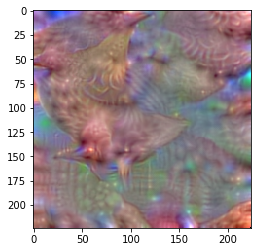

In [6]:
%%time
# 20 is the imagenet category for 'ouzel'
img = visualize_activation(model, layer_idx, filter_indices=20, max_iter=500, verbose=False)
plt.imshow(img)

More iterations definitely seem to give better output. One way to get crisper results is to use `Jitter` input_modifier. As the name suggests, `Jitter` moves pixels around in the image. Lets try this out.

CPU times: user 11.1 s, sys: 2.76 s, total: 13.8 s
Wall time: 17.8 s


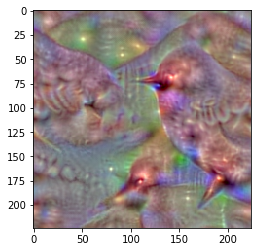

In [7]:
%%time
from vis.input_modifiers import Jitter

# 20 is the imagenet category for 'ouzel'
# Jitter 16 pixels along all dimensions during the optimization process.
img = visualize_activation(model, layer_idx, filter_indices=20, max_iter=500, input_modifiers=[Jitter(16)])
plt.imshow(img)

Look at that! Not only has the conv net captured what it means to be an ouzel, but it also seems to encode for different orientations and scales, a further proof of rotational and scale invariance. 

Lets try this for a bunch of other random categories. This will take a while. Go grab a nice cup of coffee and prepare to be amused :)

In [8]:
import json

In [9]:
with open("./imagenet_labelmap.json", "r") as f:
    labelmap = json.load(f)

# This part is a bit resource intensive! will take more than an hour in an 8 core CPU

Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default
Failed to lookup font 'FreeSans.ttf', falling back to default


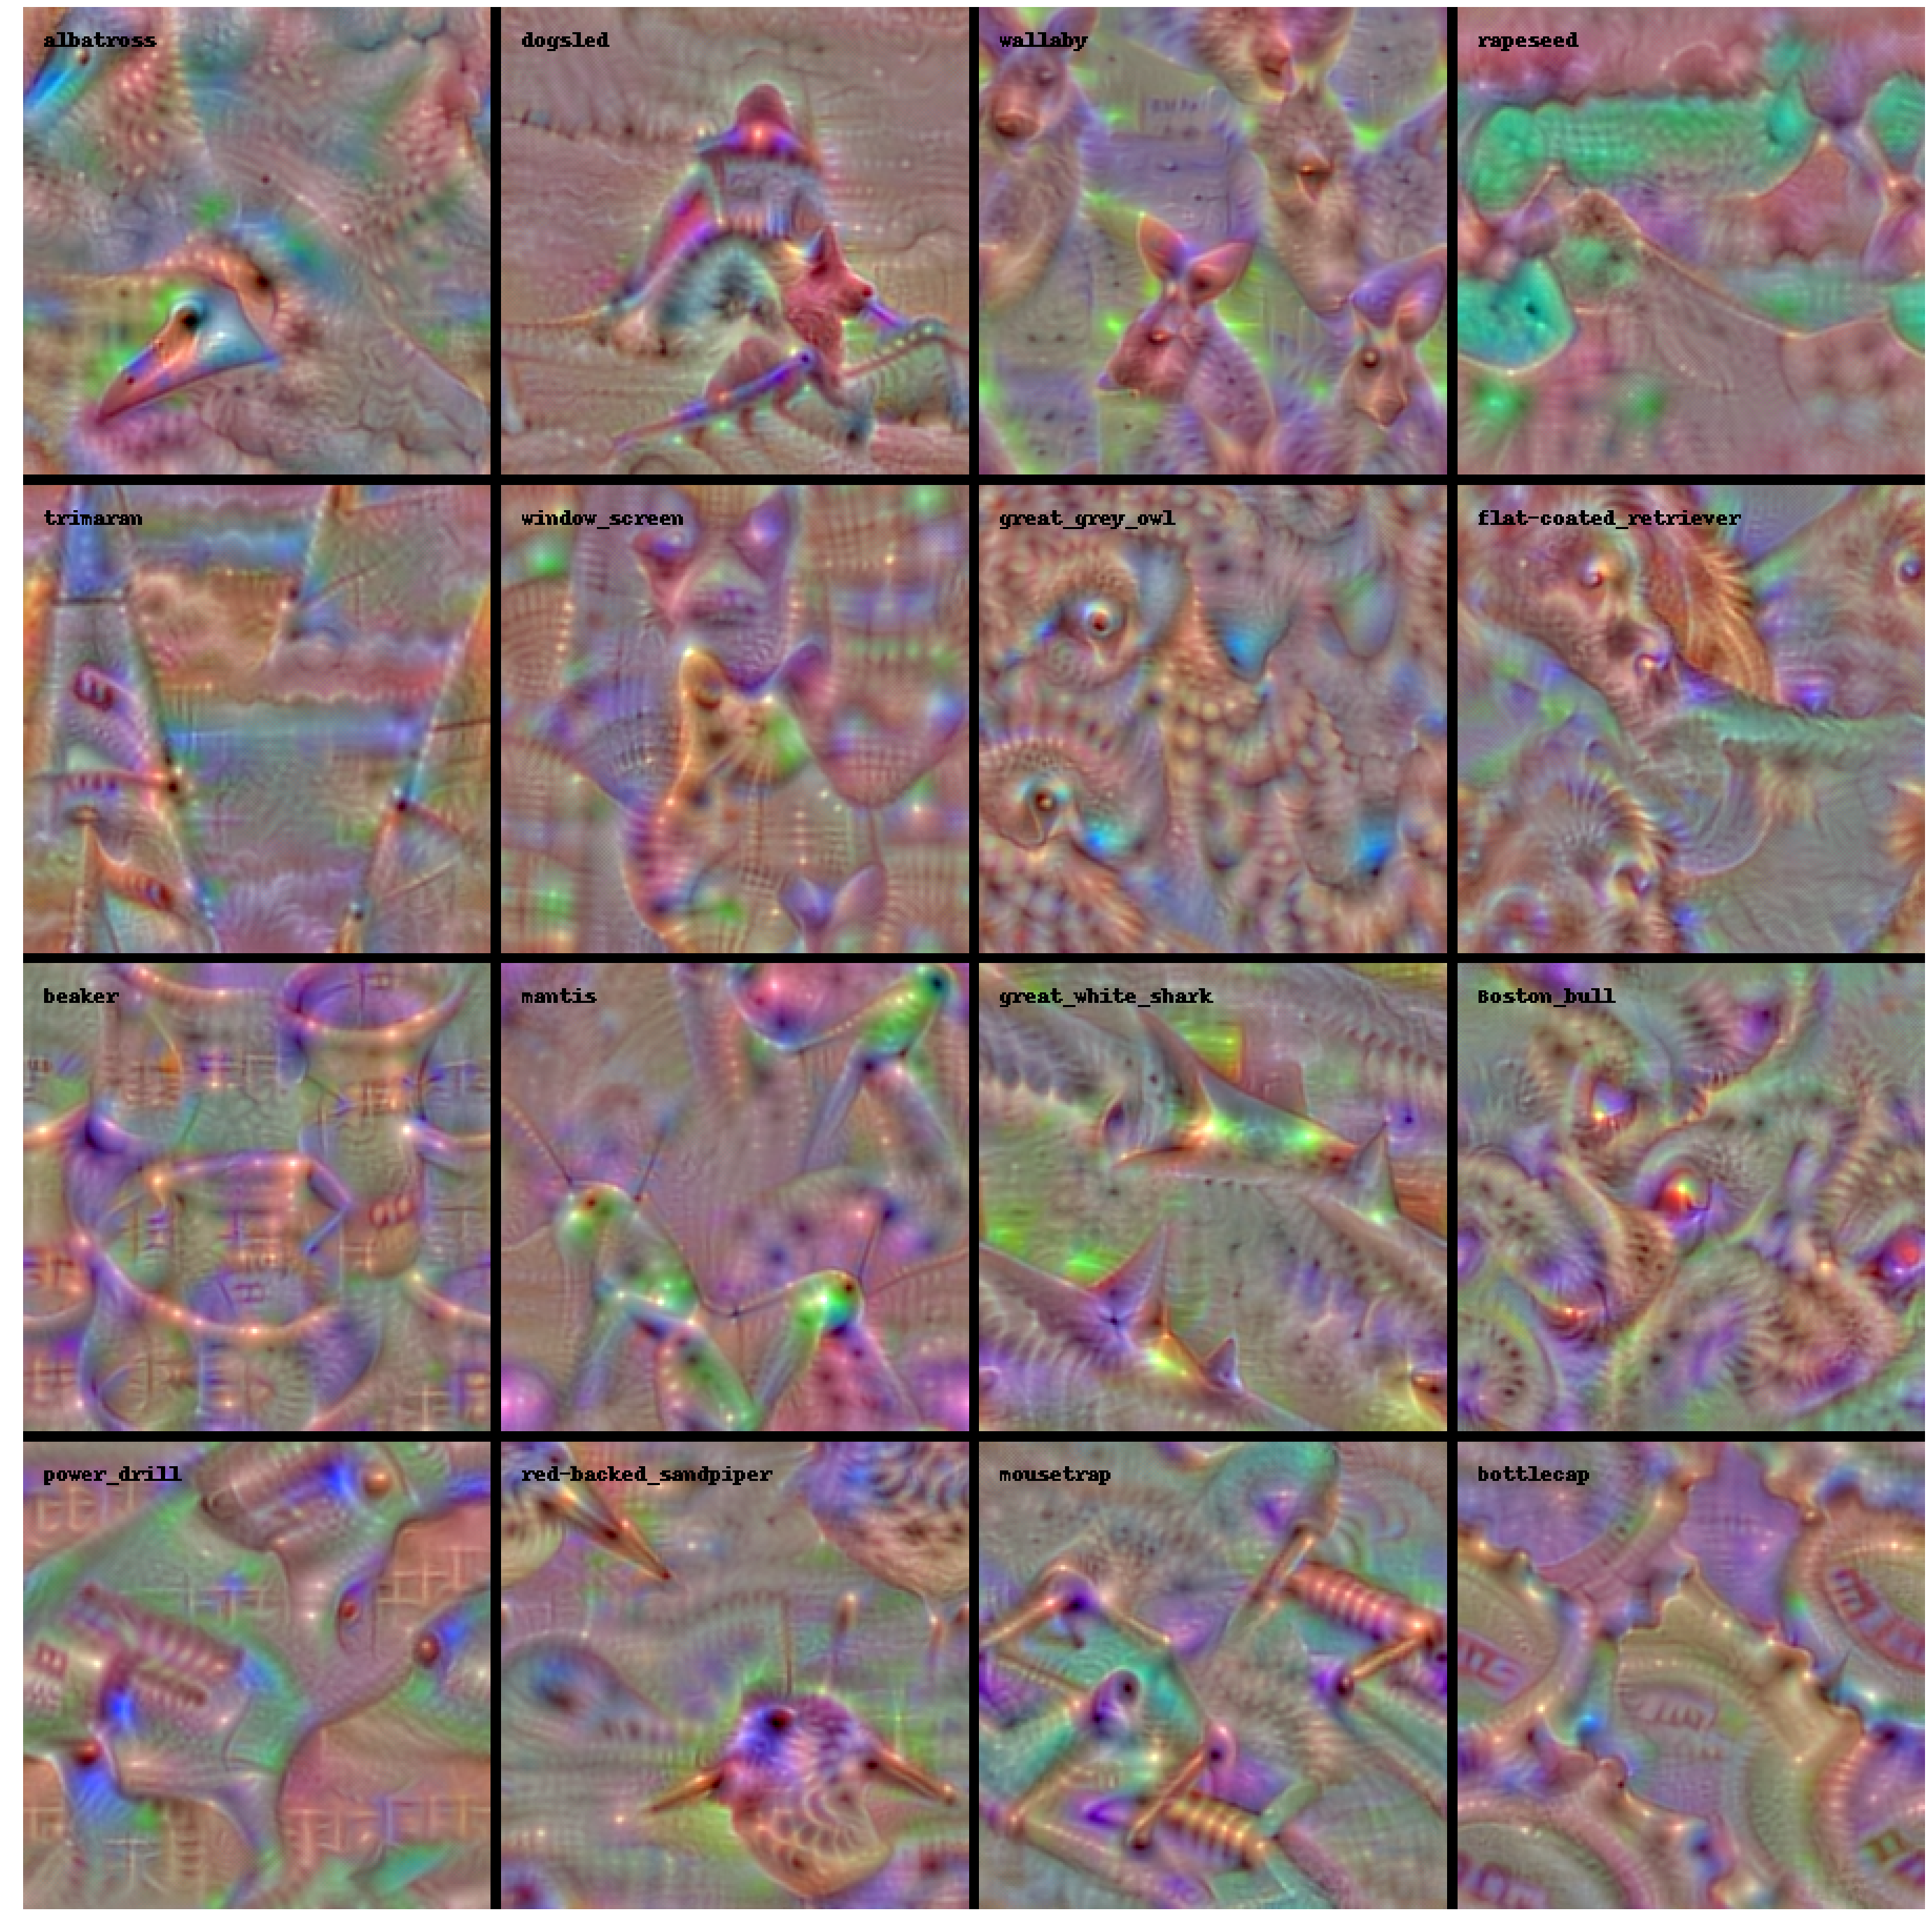

In [10]:
import numpy as np
categories = np.random.permutation(1000)[:16]

vis_images = []
image_modifiers = [Jitter(16)]
for idx in categories:    
    img = visualize_activation(model, layer_idx, filter_indices=idx, max_iter=500, input_modifiers=image_modifiers)
    
    # Reverse lookup index to imagenet label and overlay it on the image.
    img = utils.draw_text(img, labelmap[str(idx)])
    vis_images.append(img)

plt.rcParams['figure.figsize'] = (50, 50)
stitched = utils.stitch_images(vis_images, cols=4)
plt.axis('off')
plt.imshow(stitched)
plt.show()